In [1]:
import tensorflow as tf
from keras.utils import np_utils
from keras.models import load_model
import keras.backend as K
import random 
import numpy as np
import pandas as pd

from preprocessor import _imread as imread
from preprocessor import _imresize as imresize
from matplotlib import pyplot as plt
from keras.losses import categorical_crossentropy
import argparse
import glob
import os

Using TensorFlow backend.


In [2]:
K.clear_session()

W0916 00:58:43.422507 140294225913664 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:107: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0916 00:58:43.441153 140294225913664 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:111: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0916 00:58:43.444309 140294225913664 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



In [3]:
DATA_DIR = "../data/lfw"
TRAIN_TEST_SPLIT = 0.7
IM_WIDTH = IM_HEIGHT = 250
ID_RACE_MAP = {0: 'Asian', 1: 'White', 2: 'Black', 3: 'Indian'}
RACE_ID_MAP = dict((r, i) for i, r in ID_RACE_MAP.items())

ID_RACE_MAP, RACE_ID_MAP

({0: 'Asian', 1: 'White', 2: 'Black', 3: 'Indian'},
 {'Asian': 0, 'Black': 2, 'Indian': 3, 'White': 1})

In [4]:
df = pd.read_csv(DATA_DIR + "/lfw_attributes.txt", sep='\t', index_col=False)
df = df[["person", "imagenum", "Male", "Asian", "White", "Black", "Indian"]]
df = df.dropna()
df.head()

,person,imagenum,Male,Asian,White,Black,Indian
0,Aaron Eckhart,1,1.568346,-1.889043,1.737203,-0.929729,-0.071454
1,Aaron Guiel,1,0.169851,-0.982408,0.422709,-1.282184,-0.604608
2,Aaron Patterson,1,0.997749,-1.364195,-0.157377,-0.756447,-0.393042
3,Aaron Peirsol,1,1.122719,-1.997799,1.916144,-2.514214,-0.484397
4,Aaron Peirsol,2,1.078214,-2.008098,1.676211,-2.278056,-0.649715


In [30]:
df.loc[(df['Indian'] > 1.) & (df['Male'] > 0.5)]

,person,imagenum,Male,Asian,White,Black,Indian
11281,Scott Weiland,1,0.541153,-1.611059,1.32142,-2.453839,1.021981


In [15]:
def get_record_attributes(r):
    person, imagenum = r['person'], r['imagenum']
    race = (r['Asian'], r['White'], r['Black'], r['Indian'])
    gender_val = r['Male']
    person = person.replace(' ', '_')
    print(person)
    filepath = DATA_DIR + "/" + person + "/" + person + "_{:04d}.jpg".format(imagenum)
    #print(filepath)
    return filepath, gender_val, race

def random_image(sample_num=None):
    if sample_num is None:
        random_record = df.sample().iloc[0]
    else:
        random_record = df.iloc[sample_num]
    attributes = get_record_attributes(random_record)
    filepath, gender_val, race = attributes
    return filepath, gender_val, race

def preprocess_image(image, input_shape):
    image = imresize(image, input_shape[:2])
    image = image.astype('float32')
    image = image/255.0
    image = np.expand_dims(image, axis=0)
    return image

def predict(model, image):
    predictions = model.predict(image)
    return predictions

In [6]:
def FGSM(x, race_label,model,eps=0.3):
    sess = K.get_session()
    x_adv1 = x #+ (K.random_normal(x.shape) * 0.1)
    x_adv2 = x #+ (K.random_normal(x.shape) * 0.1)
    x_adv3 = x #+ (K.random_normal(x.shape) * 0.1)
    x_adv4 = x #+ (K.random_normal(x.shape) * 0.1)
    x_adv5 = x #+ (K.random_normal(x.shape) * 0.1)
    #print(list(map(lambda x: x.name, model.layers)))
    dense_out = model.get_layer('dense_9').output
    race_output = model.get_layer('race_output').output
    weights = model.get_layer('race_output').get_weights()
    
    loss = categorical_crossentropy(race_label, race_output)  
    grads = K.gradients(dense_out, model.input)
    delta = K.sign(grads[0])
    x_adv1 = x_adv1 + 0.1 * delta
    x_adv2 = x_adv2 + 0.2 * delta
    x_adv3 = x_adv3 + 0.3 * delta
    x_adv4 = x_adv4 + 0.4 * delta
    x_adv5 = x_adv5 + 0.5 * delta
    
    x_adv1 = K.clip(x_adv1, 0.0 ,1.0)
    x_adv2 = K.clip(x_adv2, 0.0 ,1.0)
    x_adv3 = K.clip(x_adv3, 0.0 ,1.0)
    x_adv4 = K.clip(x_adv4, 0.0 ,1.0)
    x_adv5 = K.clip(x_adv5, 0.0 ,1.0)

    gradients, x_adv1_array, x_adv2_array, x_adv3_array, x_adv4_array, x_adv5_array = sess.run([grads, x_adv1, x_adv2, x_adv3, x_adv4, x_adv5], feed_dict={model.input:x})
    #print('GRADIENT SUM:{}'.format(np.sum(gradients[0])))
    return x_adv1_array, x_adv2_array, x_adv3_array, x_adv4_array, x_adv5_array


In [7]:
def plot_adversarial(img_list):
    plt.figure(figsize=(8,8))
    eps = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
    for n, img in enumerate(img_list):
        ax = plt.subplot(2,3,n+1)
        ax.set_title('Epsilon: {}'.format(eps[n]))
        plt.imshow(img[0])
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [8]:
model_path = "./models/lfw_weighted_VGG_model.h5"

In [9]:
input_shape = (IM_WIDTH, IM_HEIGHT, 3)
model = load_model(model_path)

W0916 00:58:59.973206 140294225913664 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0916 00:58:59.980706 140294225913664 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0916 00:59:00.004817 140294225913664 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:4267: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0916 00:59:01.962462 140294225913664 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0916 00:59:02.137269 140294225913664 deprecation.py:323] From /usr/local/

In [9]:
img_path, gender_val, race = random_image()

image = imread(img_path)
image = preprocess_image(image, input_shape)

predictions = predict(model, image)
gender_pred, race_val = predictions

race_pred, gender_pred = race_pred.argmax(axis=-1), gender_val_to_categ(gender_pred)

print(race_pred, gender_pred)

Claudio_Ranieri


NameError: name 'race_pred' is not defined

In [10]:
def gender_val_to_categ(val, threshold = 0.5):
    if val > 0.5:
        return 1
    else:
        return 0

In [31]:
img_path, gender_val, race = random_image(11281)
print(np.array(race).argmax(axis=-1), gender_val_to_categ(gender_val))

image = imread(img_path)
image = preprocess_image(image, input_shape)

predictions = predict(model, image)
gender_pred, race_val = predictions

race_pred, gender_pred = race_val.argmax(axis=-1), gender_val_to_categ(gender_pred)

print(race_pred, gender_pred)

x_adv1, x_adv2, x_adv3, x_adv4, x_adv5 = FGSM(image,
                                              np.expand_dims(race_val, axis=0), model)
predictions_1 = predict(model, x_adv1)
predictions_2 = predict(model, x_adv2)
predictions_3 = predict(model, x_adv3)
predictions_4 = predict(model, x_adv4)
predictions_5 = predict(model, x_adv5)

gender_adv_img_1, race_adv_img_1  = predictions_1
gender_adv_img_2, race_adv_img_2  = predictions_2
gender_adv_img_3, race_adv_img_3  = predictions_3
gender_adv_img_4, race_adv_img_4  = predictions_4
gender_adv_img_5, race_adv_img_5  = predictions_5

race_adv_img_1 = race_adv_img_1.argmax(axis=-1)
race_adv_img_2 = race_adv_img_2.argmax(axis=-1)
race_adv_img_3 = race_adv_img_3.argmax(axis=-1)
race_adv_img_4 = race_adv_img_4.argmax(axis=-1)
race_adv_img_5 = race_adv_img_5.argmax(axis=-1)

gender_adv_img_1 = gender_val_to_categ(gender_adv_img_1)
gender_adv_img_2 = gender_val_to_categ(gender_adv_img_2)
gender_adv_img_3 = gender_val_to_categ(gender_adv_img_3)
gender_adv_img_4 = gender_val_to_categ(gender_adv_img_4)
gender_adv_img_5 = gender_val_to_categ(gender_adv_img_5)

print(race_adv_img_1, gender_adv_img_1)
print(race_adv_img_2, gender_adv_img_2)
print(race_adv_img_3, gender_adv_img_3)
print(race_adv_img_4, gender_adv_img_4)
print(race_adv_img_5, gender_adv_img_5)

Scott_Weiland
(1, 1)
(array([2]), 1)
(array([2]), 0)
(array([2]), 0)
(array([2]), 0)
(array([2]), 0)
(array([2]), 0)


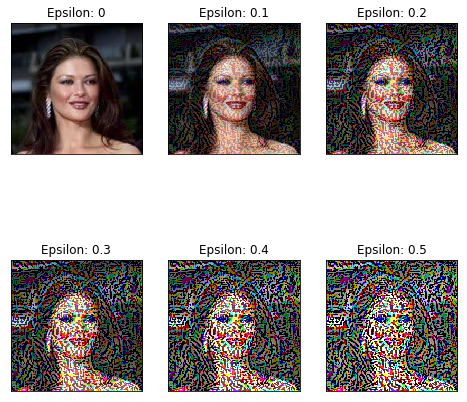

In [18]:
plot_adversarial([image, x_adv1, x_adv2, x_adv3, x_adv4, x_adv5])

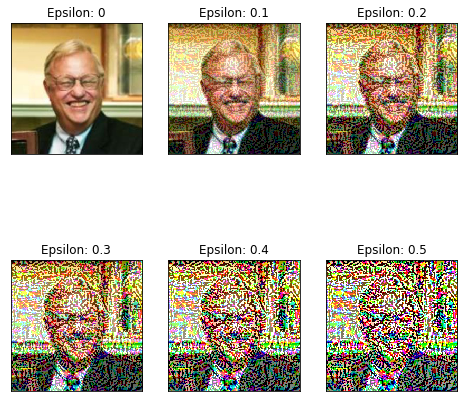

In [20]:
plot_adversarial([image, x_adv1, x_adv2, x_adv3, x_adv4, x_adv5])

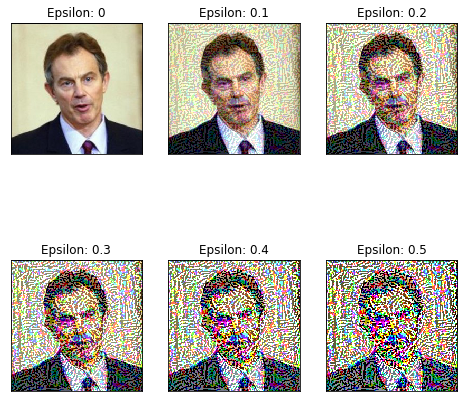

In [22]:
plot_adversarial([image, x_adv1, x_adv2, x_adv3, x_adv4, x_adv5])

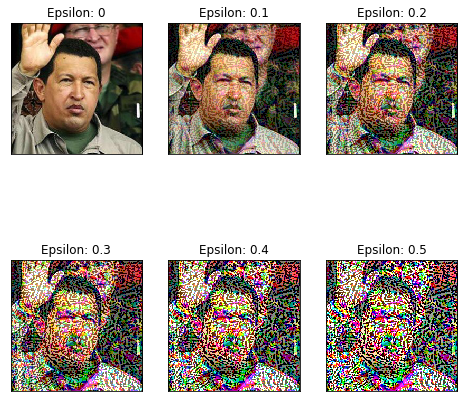

In [24]:
plot_adversarial([image, x_adv1, x_adv2, x_adv3, x_adv4, x_adv5])

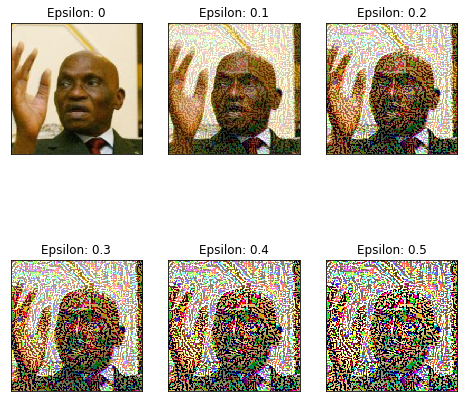

In [17]:
plot_adversarial([image, x_adv1, x_adv2, x_adv3, x_adv4, x_adv5])

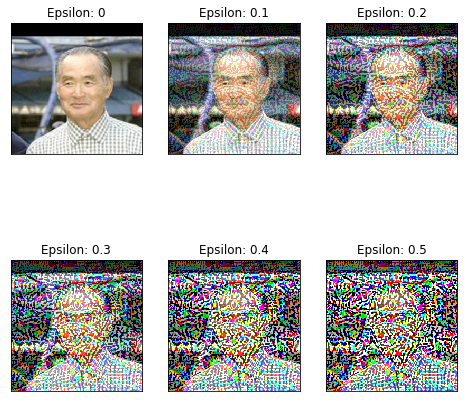

In [22]:
plot_adversarial([image, x_adv1, x_adv2, x_adv3, x_adv4, x_adv5])

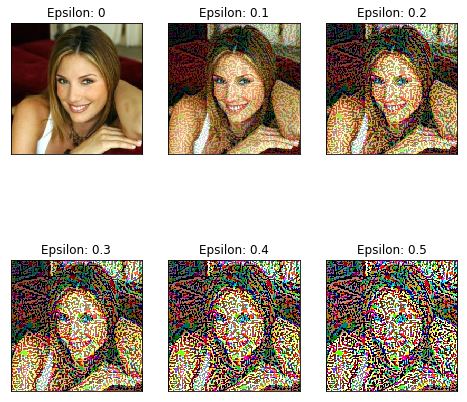

In [25]:
plot_adversarial([image, x_adv1, x_adv2, x_adv3, x_adv4, x_adv5])

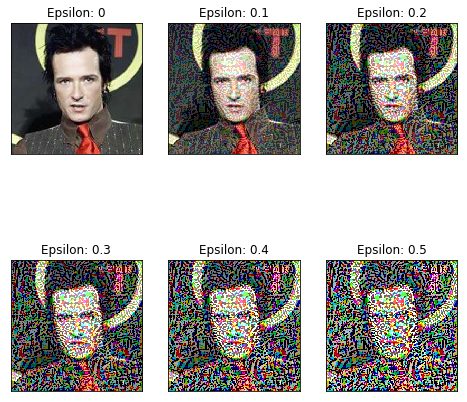

In [32]:
plot_adversarial([image, x_adv1, x_adv2, x_adv3, x_adv4, x_adv5])